<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/trading_strategy_10SL_10TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip  install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


In [18]:
# ✅ Download most recent 1-hour stock data (Max available: last 720 days)
df = yf.download("AAPL", period="720d", interval="1h")

# ✅ Print actual column names to check the structure
print("Original column names:", df.columns)

[*********************100%***********************]  1 of 1 completed

Original column names: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [19]:
# ✅ Fix Multi-Index Columns: Extract only the first level (Price Type)
df.columns = df.columns.get_level_values(0)  # Extract 'Close', 'High', 'Low', 'Open', 'Volume'

# ✅ Reset index to make "Datetime" a column
df = df.reset_index()


In [20]:
# ✅ Keep only relevant columns
df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

# ✅ Verify DataFrame
print(df.head())

Price                  Datetime        Open        High         Low  \
0     2022-03-28 13:30:00+00:00  172.169998  175.000000  172.000000   
1     2022-03-28 14:30:00+00:00  174.345001  175.005005  173.699997   
2     2022-03-28 15:30:00+00:00  174.375000  174.395004  173.080002   
3     2022-03-28 16:30:00+00:00  173.410004  174.600006  173.330002   
4     2022-03-28 17:30:00+00:00  174.440002  174.800003  174.150604   

Price       Close    Volume  
0      174.339996  25291677  
1      174.380005  11578517  
2      173.399994   8979815  
3      174.441803   6460224  
4      174.740097   7178077  


In [21]:
# ✅ Reset index to make "Datetime" a column
df = df.reset_index()

# ✅ Keep only relevant columns
df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]

# ✅ Verify DataFrame
print(df.head())

Price                  Datetime        Open        High         Low  \
0     2022-03-28 13:30:00+00:00  172.169998  175.000000  172.000000   
1     2022-03-28 14:30:00+00:00  174.345001  175.005005  173.699997   
2     2022-03-28 15:30:00+00:00  174.375000  174.395004  173.080002   
3     2022-03-28 16:30:00+00:00  173.410004  174.600006  173.330002   
4     2022-03-28 17:30:00+00:00  174.440002  174.800003  174.150604   

Price       Close    Volume  
0      174.339996  25291677  
1      174.380005  11578517  
2      173.399994   8979815  
3      174.441803   6460224  
4      174.740097   7178077  


In [22]:
print(df.isnull().sum())  # Check for NaNs
df.dropna(inplace=True)  # Remove missing values

Price
Datetime    0
Open        0
High        0
Low         0
Close       0
Volume      0
dtype: int64


In [23]:
print(df.dtypes)  # Ensure Datetime is correctly formatted
df['Datetime'] = pd.to_datetime(df['Datetime'])  # Convert if necessary

Price
Datetime    datetime64[ns, UTC]
Open                    float64
High                    float64
Low                     float64
Close                   float64
Volume                    int64
dtype: object


In [24]:
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()

df['Bollinger_Upper'] = df['SMA_10'] + (df['Close'].rolling(10).std() * 2)
df['Bollinger_Lower'] = df['SMA_10'] - (df['Close'].rolling(10).std() * 2)

In [25]:
df['Buy_Signal'] = (df['SMA_10'] > df['SMA_50']) & (df['SMA_10'].shift(1) <= df['SMA_50'].shift(1))
df['Sell_Signal'] = (df['SMA_10'] < df['SMA_50']) & (df['SMA_10'].shift(1) >= df['SMA_50'].shift(1))

Final Portfolio Value: $13350.20
Profit/Loss: $3350.20
New Win Rate: 63.64%
Trade Log: ['BUY at 170.70', 'SELL (Stop-Loss) at 148.56', 'BUY at 143.98', 'SELL (Take-Profit) at 163.27', 'BUY at 161.63', 'SELL (Stop-Loss) at 141.27', 'BUY at 146.76', 'SELL (Stop-Loss) at 127.61', 'BUY at 129.52', 'SELL (Take-Profit) at 142.71', 'BUY at 145.53', 'SELL (Take-Profit) at 160.22', 'BUY at 160.78', 'SELL (Take-Profit) at 177.61', 'BUY at 181.23', 'SELL (Take-Profit) at 200.90', 'BUY at 213.26', 'SELL (Take-Profit) at 234.79', 'BUY at 222.93', 'SELL (Take-Profit) at 246.47', 'BUY at 230.68', 'FINAL SELL at 227.71']


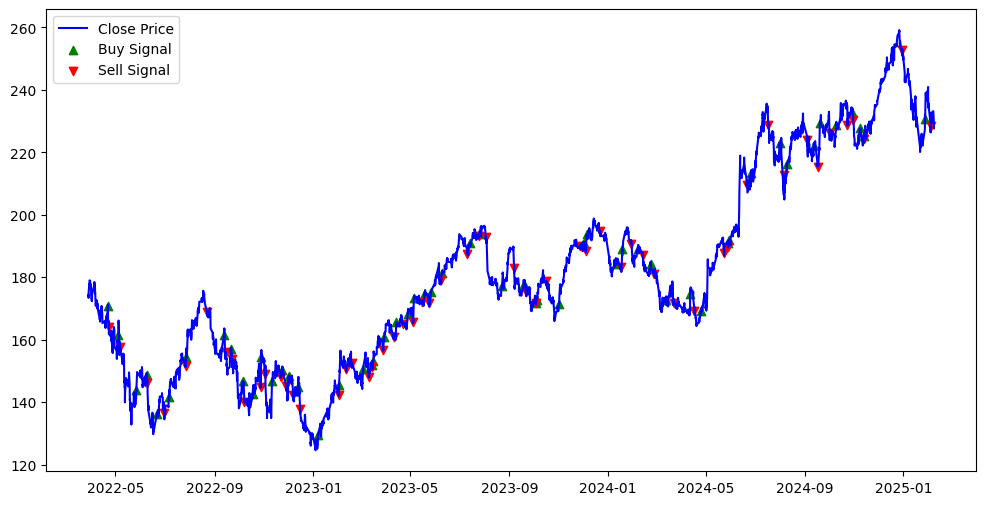

In [26]:
# Initialize capital and trade log
initial_capital = 10000
capital = initial_capital
shares = 0
trade_log = []

# Adjusted Stop-Loss & Take-Profit
STOP_LOSS_PERCENT = 0.88  # Stop-Loss at 12% drop
TAKE_PROFIT_PERCENT = 1.10  # Take-Profit at 10% gain

buy_price = None
last_trade_index = -5  # To prevent overtrading

for i in range(len(df)):
    price = df['Close'].iloc[i]

    if df['Buy_Signal'].iloc[i] and (i - last_trade_index) > 3 and capital >= price * 10:
        buy_price = price
        shares = capital // price
        capital -= shares * price
        trade_log.append(f"BUY at {price:.2f}")
        last_trade_index = i  # Store trade index to prevent overtrading

    elif shares > 0:  # Sell Condition (Stop-Loss & Take-Profit)
        if price >= buy_price * TAKE_PROFIT_PERCENT:  # Take-Profit
            capital += shares * price
            shares = 0
            trade_log.append(f"SELL (Take-Profit) at {price:.2f}")

        elif price <= buy_price * STOP_LOSS_PERCENT:  # Stop-Loss
            capital += shares * price
            shares = 0
            trade_log.append(f"SELL (Stop-Loss) at {price:.2f}")

# Ensure final sell if holding stocks
if shares > 0:
    capital += shares * df['Close'].iloc[-1]
    trade_log.append(f"FINAL SELL at {df['Close'].iloc[-1]:.2f}")

# Calculate the new Win Rate
profit_trades = sum([1 for i in range(1, len(trade_log), 2) if float(trade_log[i].split(" at ")[1]) > float(trade_log[i-1].split(" at ")[1])])
total_trades = len(trade_log) // 2
win_rate = (profit_trades / total_trades) * 100 if total_trades > 0 else 0

# Print Performance Metrics
print(f"Final Portfolio Value: ${capital:.2f}")
print(f"Profit/Loss: ${capital - initial_capital:.2f}")
print(f"New Win Rate: {win_rate:.2f}%")
print(f"Trade Log: {trade_log}")

# Plot Buy/Sell Trades
df['Buy_Signal'] = df['Buy_Signal'].astype(bool)
df['Sell_Signal'] = df['Sell_Signal'].astype(bool)

plt.figure(figsize=(12,6))
plt.plot(df['Datetime'], df['Close'], label='Close Price', color='blue')
plt.scatter(df[df['Buy_Signal']]['Datetime'], df[df['Buy_Signal']]['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(df[df['Sell_Signal']]['Datetime'], df[df['Sell_Signal']]['Close'], marker='v', color='red', label='Sell Signal')
plt.legend()
plt.show()
